![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/03.2.Clinical_RE_Knowledge_Graph_with_Neo4j.ipynb)

# Clinical Relation Extraction Model Visualization with Neo4j

## Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install -q johnsnowlabs==5.1.0

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, medical, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install()

In [ ]:
from johnsnowlabs import nlp, medical, visual

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

In [5]:
spark

# Clinical Temporal Events RE

Temporal relations, or temporal links (denoted by the TLINK tag), indicate whether and how two EVENTs, two TIME, or an EVENT and a TIME related to each other in the clinical timeline. There are 3 type of relations here and below are some examples of Relations, with square brackets indicating EVENT and TIME connected by a temporal link:

**`BEFORE`**

The patient was given stress dose steroids prior to his surgery. ([stress dose steroids] `BEFORE` [his surgery])

The patient had an undocumented history of possible atrial fibrillation prior to admission. ([possible atrial fibrillation] `BEFORE` [admission])

His nasogastric tube was discontinued on 05-26-98. ([His nasogastric] `BEFORE` [05-26-98])

**`AFTER`**

Before admission, he had another serious concussion. ([admission] `AFTER` [another serious concussion])

On postoperative day No 1, he was started on Percocet. ([Percocet] `AFTER` [postoperative day No 1])


**`OVERLAP`**

She denies any fevers or chills. ([fevers] `OVERLAP` [chills])

The patient's serum creatinine on discharge date, 2012-05-06, was 1.9. ([discharge date] `OVERLAP` [2012-05-06])

His preoperative workup was completed and included a normal white count ([a normal white count] `OVERLAP` [His preoperative workup])

The patient had an undocumented history of possible atrial fibrillation prior to admission. ([possible atrial fibrillation] `OVERLAP` [admission])


| Relation | Recall | Precision | F1 |
| --- | --- | --- | --- |
| OVERLAP | 0.81 | 0.73 | **0.77** |
| BEFORE | 0.85 | 0.88 | **0.86** |
| AFTER | 0.38 | 0.46 | **0.43** |



This RE model works with `ner_events_clinical` NER model and expect the following entities as inputs:

[`OCCURRENCE`,
 `DATE`,
 `DURATION`,
 `EVIDENTIAL`,
 `TEST`,
 `PROBLEM`,
 `TREATMENT`,
 `CLINICAL_DEPT`,
 `FREQUENCY`,
 `TIME`]

## Pipeline

In [ ]:
documenter = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencer = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")

words_embedder = nlp.WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("embeddings")

pos_tagger = nlp.PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("pos_tags")

events_admission_ner_tagger = medical.NerModel()\
    .pretrained("ner_events_admission_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")

ner_chunker = medical.NerConverterInternal()\
    .setInputCols(["sentences", "tokens", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = nlp.DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentences", "pos_tags", "tokens"])\
    .setOutputCol("dependencies")

clinical_re_Model = medical.RelationExtractionModel()\
    .pretrained("re_temporal_events_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.9)

pipeline = nlp.Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer,
    words_embedder,
    pos_tagger,
    events_admission_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
ner_events_admission_clinical download started this may take some time.
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
re_temporal_events_clinical download started this may take some time.
[OK!]


In [ ]:
import pandas as pd

def get_relations_df (results, col='relations'):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.result,
          rel.metadata['entity1'],
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'],
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'],
          rel.metadata['confidence']
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])

  return rel_df


**Create a light pipeline for annotating free text**

In [ ]:
text ="""She is admitted to The John Hopkins Hospital on Monday with a history of gestational diabetes mellitus diagnosed.
She was seen by the endocrinology service and she was discharged on 03/02/2018 on 40 units of insulin glargine,
12 units of insulin lispro, and metformin 1000 mg two times a day. She had close follow-up with endocrinology post discharge.
"""

lmodel = nlp.LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df = rel_df[(rel_df.relation!="O")]

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,AFTER,ADMISSION,7,14,admitted,CLINICAL_DEPT,19,43,The John Hopkins Hospital,0.982727
1,OVERLAP,ADMISSION,7,14,admitted,DATE,48,53,Monday,1.000000
2,OVERLAP,CLINICAL_DEPT,19,43,The John Hopkins Hospital,DATE,48,53,Monday,1.000000
3,BEFORE,DATE,48,53,Monday,PROBLEM,73,101,gestational diabetes mellitus,0.988257
4,OVERLAP,CLINICAL_DEPT,132,156,the endocrinology service,DATE,184,193,03/02/2018,0.987573
5,OVERLAP,DISCHARGE,170,179,discharged,DATE,184,193,03/02/2018,1.000000
6,AFTER,DISCHARGE,170,179,discharged,TREATMENT,210,225,insulin glargine,0.973975
7,AFTER,DISCHARGE,170,179,discharged,TREATMENT,241,254,insulin lispro,0.941394
8,OVERLAP,DATE,184,193,03/02/2018,TREATMENT,241,254,insulin lispro,0.980152
9,OVERLAP,TREATMENT,261,269,metformin,FREQUENCY,279,293,two times a day,1.000000


## Neo4j Connection

In [ ]:
!pip install -q neo4j
!pip install -q tqdm

In [ ]:
from neo4j import GraphDatabase
import time
from tqdm import tqdm

### Connection Helper Class & Functions

In [ ]:
class Neo4jConnection:

    def __init__(self, uri, user, pwd):

        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None

        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):

        if self.__driver is not None:
            self.__driver.close()

    def query(self, query, parameters=None, db=None):

        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None

        try:
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

In [ ]:
def update_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.
    # Especially for large datasets.
    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query, parameters={'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total, "batches":batch, "time":time.time()-start}
        print(result)

    return result

In [ ]:
def add_ners_rels(rows, batch_size=10000):
    # Adds NER nodes to the Neo4j graph as a batch job.
    query = '''
    //chunk1 NERs
    UNWIND $rows as row
    MERGE(n1:NER{name:row.chunk1}) ON CREATE SET n1.type=row.entity1

    //chunk2 NERs
    MERGE(n2:NER{name:row.chunk2}) ON CREATE SET n2.type=row.entity2

    //connect NERs
    WITH row, n1, n2
    MERGE (n1)-[:LINKS{relation:row.relation}]->(n2)

    WITH n1
    MATCH (n1)
    RETURN count(*) as total
    '''

    return update_data(query, rows, batch_size)

In [ ]:
uri = 'neo4j+s://5731566c.databases.neo4j.io'
pwd = 'JBJUYsLaCf8jJji7DSh3aSgkgM1c1wHFb38l2XbuDPk'
user= 'neo4j'

conn = Neo4jConnection(uri=uri, user=user , pwd=pwd)

**Important Note :** Before run any Neo4j query, you should delete all nodes and relatioships.

In [ ]:
delete_all_nodes = 'MATCH (n) DETACH DELETE n;'
conn.query(delete_all_nodes)

[]

In [ ]:
const_ners = 'CREATE CONSTRAINT ners IF NOT EXISTS ON (n:NER) ASSERT n.name IS UNIQUE'
conn.query(const_ners)

[]

In [ ]:
add_ners_rels(rel_df)

{'total': 14, 'batches': 1, 'time': 0.22846102714538574}


{'total': 14, 'batches': 1, 'time': 0.22846102714538574}

**Visualization at Neo4j Sandbox**

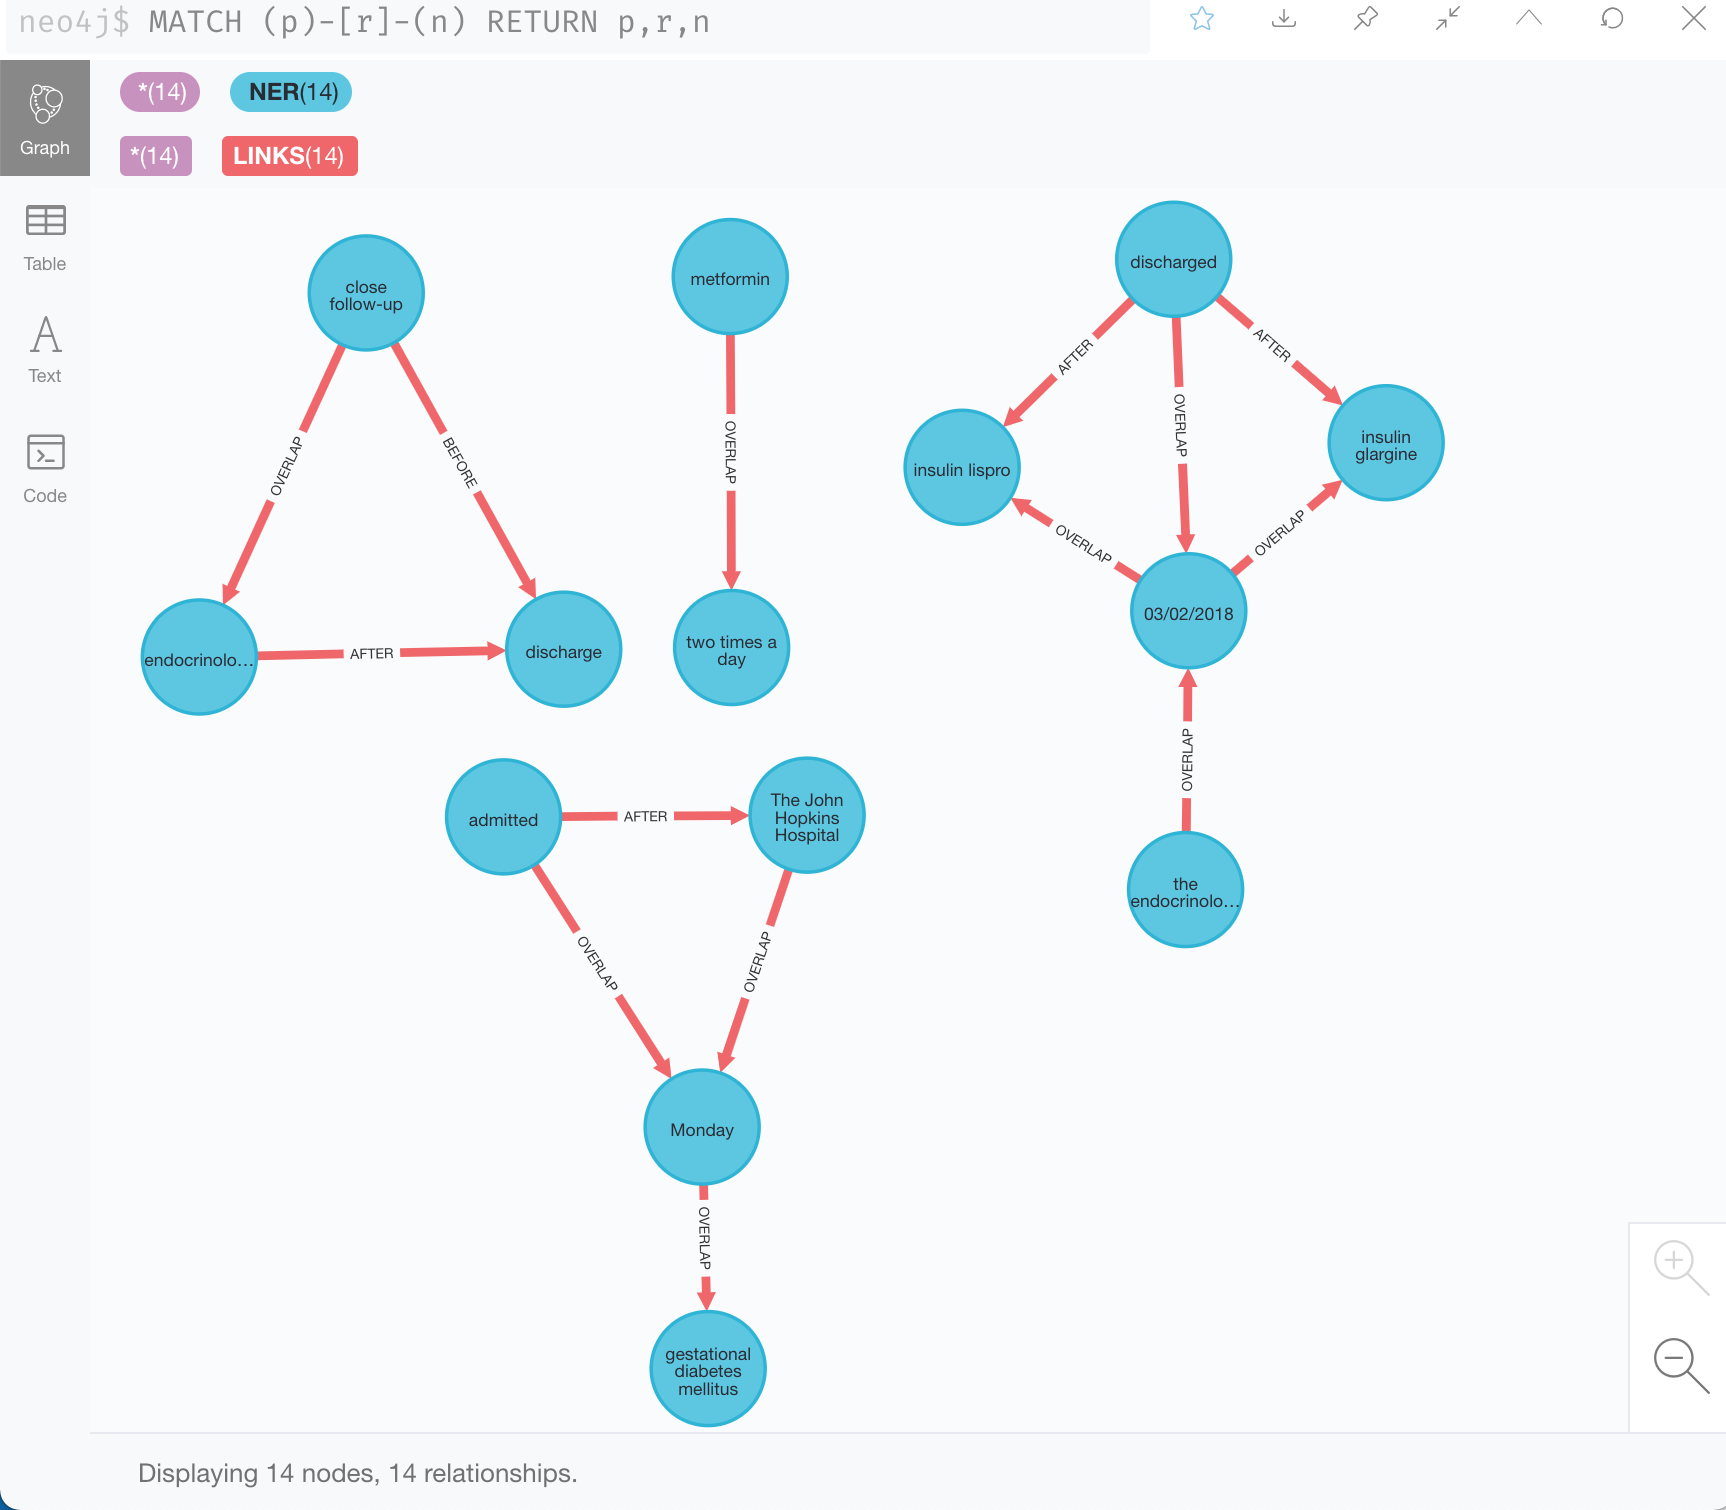

### Quering the Neo4j Database to Get Some Results

In [ ]:
query_string = '''
MATCH (n1)-[r]-(n2)
RETURN n1.name, n1.type, r.relation, n2.name, n2.type
'''
all_nodes_rels = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
all_nodes_rels.head(20)

,n1.name,n1.type,r.relation,n2.name,n2.type
0,admitted,ADMISSION,AFTER,The John Hopkins Hospital,CLINICAL_DEPT
1,admitted,ADMISSION,OVERLAP,Monday,DATE
2,The John Hopkins Hospital,CLINICAL_DEPT,AFTER,admitted,ADMISSION
3,The John Hopkins Hospital,CLINICAL_DEPT,OVERLAP,Monday,DATE
4,Monday,DATE,OVERLAP,gestational diabetes mellitus,PROBLEM
5,Monday,DATE,OVERLAP,The John Hopkins Hospital,CLINICAL_DEPT
6,Monday,DATE,OVERLAP,admitted,ADMISSION
7,the endocrinology service,CLINICAL_DEPT,OVERLAP,03/02/2018,DATE
8,discharged,DISCHARGE,AFTER,insulin lispro,TREATMENT
9,discharged,DISCHARGE,AFTER,insulin glargine,TREATMENT


In [ ]:
query = """
    MATCH (n1:NER {type: $disc})-[]-(n2:NER {type: $treat})
    RETURN n1.name AS disc, n2.name AS treatment
"""

params = {'disc':'DISCHARGE', 'treat':'TREATMENT'}

df = pd.DataFrame([dict(_) for _ in conn.query(query, parameters=params)])
df

,disc,treatment
0,discharged,insulin lispro
1,discharged,insulin glargine


In [ ]:
query = """
    MATCH (n1:NER {type: 'DATE'})-[r]-(n2:NER)
    RETURN n1.name AS date, r.relation AS relation, n2.name AS event
"""

df = pd.DataFrame([dict(_) for _ in conn.query(query)])
df

,date,relation,event
0,Monday,OVERLAP,gestational diabetes mellitus
1,Monday,OVERLAP,The John Hopkins Hospital
2,Monday,OVERLAP,admitted
3,03/02/2018,OVERLAP,insulin lispro
4,03/02/2018,OVERLAP,insulin glargine
5,03/02/2018,OVERLAP,discharged
6,03/02/2018,OVERLAP,the endocrinology service


**Visualization at Neo4j Sandbox**

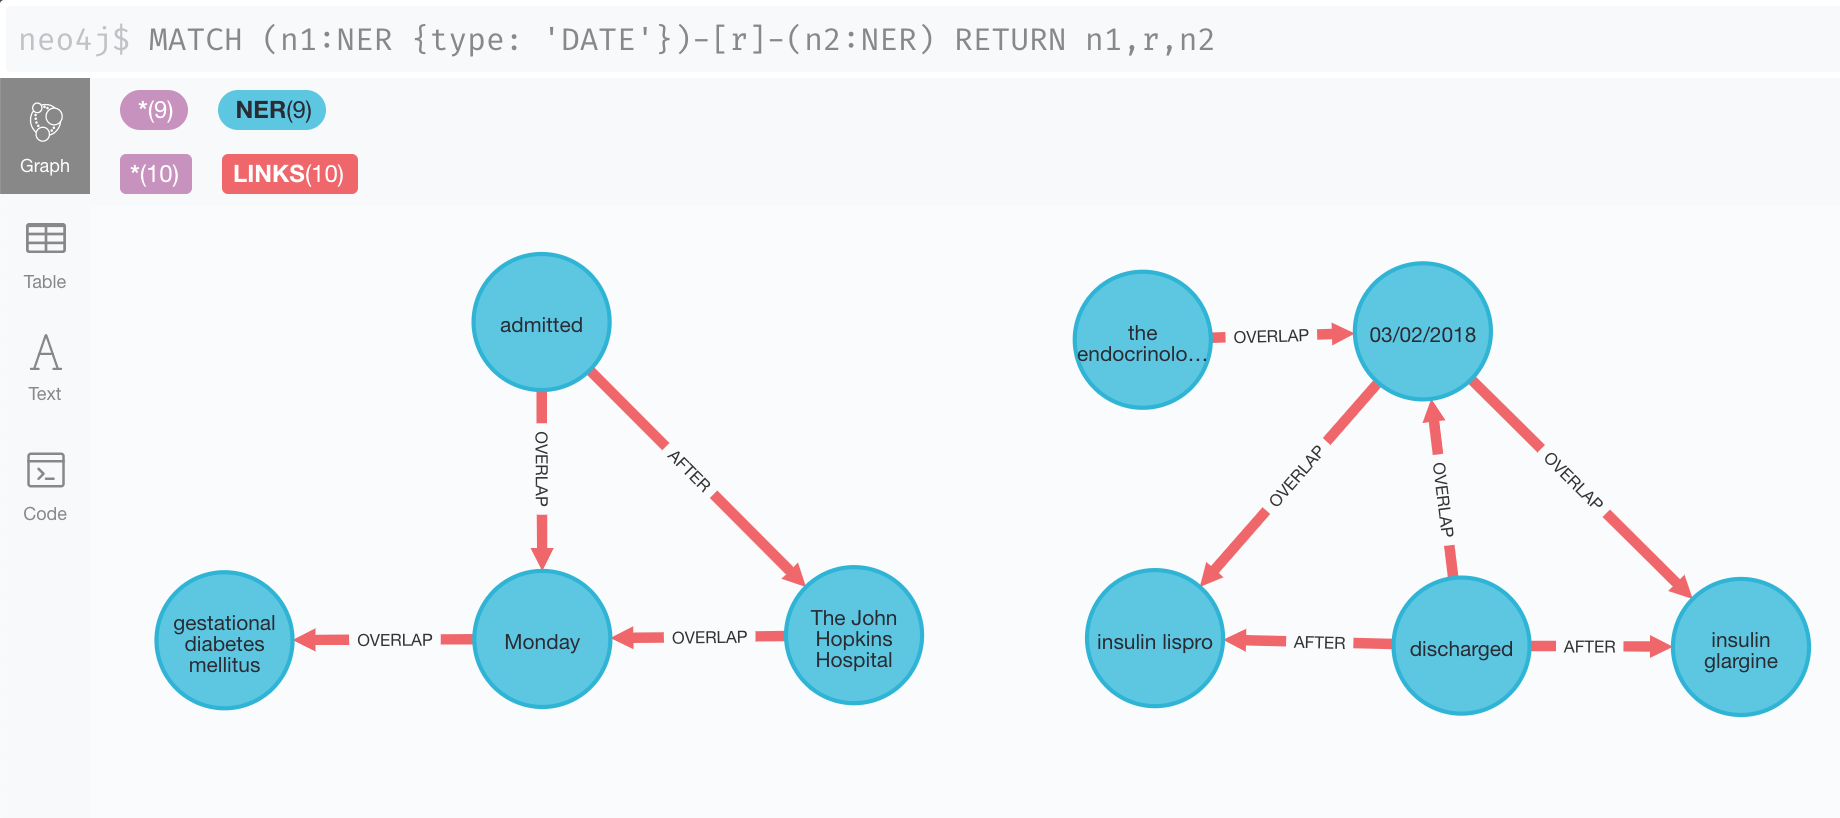

In [ ]:
conn.close()

# Clinical RE

**The set of relations defined in the 2010 i2b2 relation challenge**

TrIP: A certain treatment has improved or cured a medical problem (eg, ‘infection resolved with antibiotic course’)

TrWP: A patient's medical problem has deteriorated or worsened because of or in spite of a treatment being administered (eg, ‘the tumor was growing despite the drain’)

TrCP: A treatment caused a medical problem (eg, ‘penicillin causes a rash’)

TrAP: A treatment administered for a medical problem (eg, ‘Dexamphetamine for narcolepsy’)

TrNAP: The administration of a treatment was avoided because of a medical problem (eg, ‘Ralafen which is contra-indicated because of ulcers’)

TeRP: A test has revealed some medical problem (eg, ‘an echocardiogram revealed a pericardial effusion’)

TeCP: A test was performed to investigate a medical problem (eg, ‘chest x-ray done to rule out pneumonia’)

PIP: Two problems are related to each other (eg, ‘Azotemia presumed secondary to sepsis’)

## Pipeline

In [ ]:
documenter = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencer = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")

words_embedder = nlp.WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("embeddings")

pos_tagger = nlp.PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("pos_tags")

ner_tagger = medical.NerModel()\
    .pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")

clinical_ner_tagger = medical.NerModel()\
    .pretrained("ner_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")

ner_chunker = medical.NerConverterInternal()\
    .setInputCols(["sentences", "tokens", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = nlp.DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentences", "pos_tags", "tokens"])\
    .setOutputCol("dependencies")

clinical_re_Model = medical.RelationExtractionModel()\
    .pretrained("re_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setRelationPairs(["problem-test", "problem-treatment"]) # we can set the possible relation pairs (if not set, all the relations will be calculated)

pipeline = nlp.Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer,
    words_embedder,
    pos_tagger,
    clinical_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_Model
])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
ner_posology download started this may take some time.
[OK!]
ner_clinical download started this may take some time.
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
re_clinical download started this may take some time.
[OK!]


In [ ]:
def get_relations_df (results, col='relations'):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.result,
          rel.metadata['entity1'],
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'],
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'],
          rel.metadata['confidence']
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])

  return rel_df

**Create a light pipeline for annotating free text**

In [ ]:
text = """
A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ),
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with acute hepatitis, and obesity with a body mass index ( BMI ) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. Two weeks prior to presentation, she was treated with a five-day course of amoxicillin for a respiratory tract infection. She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for starvation ketosis, as she reported poor oral intake for three days prior to admission. However, serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL, the anion gap was still elevated at 21, serum bicarbonate was 16 mmol/L, triglyceride level peaked at 2050 mg/dL, and lipase was 52 U/L. The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again. The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL, within 24 hours. Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use. The patient was seen by the endocrinology service and she was discharged on 1 unit of Advil for 5 days after meals, 40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg two times a day. It was determined that all SGLT2 inhibitors should be discontinued indefinitely.
She had a close follow-up with endocrinology post-discharge.
"""

lmodel = nlp.LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df = rel_df[rel_df.relation!="O"]
rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
2,TeRP,TEST,319,321,BMI,PROBLEM,377,384,polyuria,0.9990237
4,TeRP,TEST,319,321,BMI,PROBLEM,399,411,poor appetite,0.98353875
5,TrAP,TEST,319,321,BMI,PROBLEM,418,425,vomiting,0.994678
6,TrAP,TREATMENT,503,513,amoxicillin,PROBLEM,519,547,a respiratory tract infection,0.99998844
7,TrAP,TREATMENT,561,569,metformin,PROBLEM,607,610,T2DM,0.9999993
8,TrAP,TREATMENT,573,581,glipizide,PROBLEM,607,610,T2DM,0.9999999
9,TrAP,TREATMENT,589,601,dapagliflozin,PROBLEM,607,610,T2DM,0.99999976
10,TrAP,TREATMENT,589,601,dapagliflozin,PROBLEM,649,651,HTG,0.9998598
13,TrAP,TREATMENT,616,627,atorvastatin,PROBLEM,649,651,HTG,0.99999547
14,TrAP,TREATMENT,633,643,gemfibrozil,PROBLEM,649,651,HTG,1.0


## Neo4j Connection

In [ ]:
from neo4j import GraphDatabase
import time
from tqdm import tqdm

### Connection Helper Class & Functions

In [ ]:
class Neo4jConnection:

    def __init__(self, uri, user, pwd):

        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None

        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):

        if self.__driver is not None:
            self.__driver.close()

    def query(self, query, parameters=None, db=None):

        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None

        try:
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

In [ ]:
def update_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.
    # Especially for large datasets.
    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query, parameters={'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total, "batches":batch, "time":time.time()-start}
        print(result)

    return result

In [ ]:
def add_ners_rels(rows, batch_size=10000):
    # Adds NER nodes to the Neo4j graph as a batch job.
    query = '''
    //chunk1 NERs
    UNWIND $rows as row
    MERGE(n1:NER{name:row.chunk1}) ON CREATE SET n1.type=row.entity1

    //chunk2 NERs
    MERGE(n2:NER{name:row.chunk2}) ON CREATE SET n2.type=row.entity2

    //connect NERs
    WITH row, n1, n2
    MERGE (n1)-[:LINKS{relation:row.relation}]->(n2)

    WITH n1
    MATCH (n1)
    RETURN count(*) as total
    '''

    return update_data(query, rows, batch_size)

In [ ]:
uri = 'neo4j+s://5731566c.databases.neo4j.io'
pwd = 'JBJUYsLaCf8jJji7DSh3aSgkgM1c1wHFb38l2XbuDPk'
user= 'neo4j'

conn = Neo4jConnection(uri=uri, user=user , pwd=pwd)

**Important Note :** Before run any Neo4j query, you should delete all nodes and relatioships.

In [ ]:
delete_all_nodes = 'MATCH (n) DETACH DELETE n;'
conn.query(delete_all_nodes)

[]

In [ ]:
const_ners = 'CREATE CONSTRAINT ners IF NOT EXISTS ON (n:NER) ASSERT n.name IS UNIQUE'
conn.query(const_ners)

[]

In [ ]:
add_ners_rels(rel_df)

{'total': 7, 'batches': 1, 'time': 0.2249617576599121}


{'total': 7, 'batches': 1, 'time': 0.2249617576599121}

**Visualization at Neo4j Sandbox**

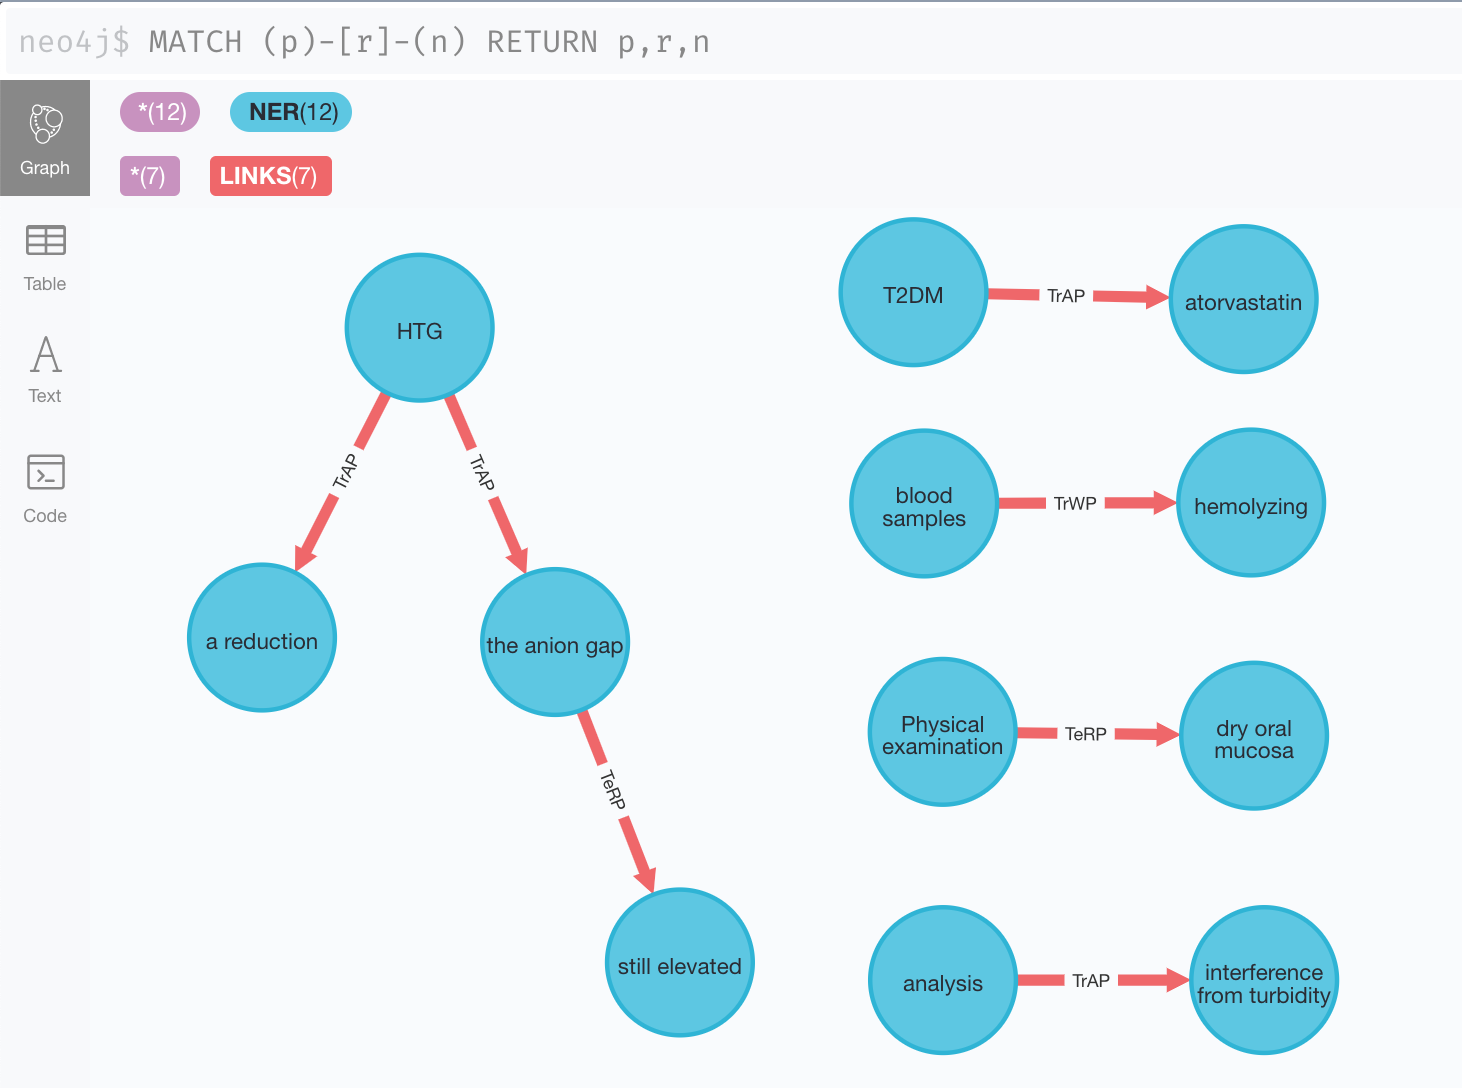

### Quering the Neo4j Database to Get Some Results

In [ ]:
query_string = '''
MATCH (n1)-[r]-(n2)
RETURN n1.name, n1.type, r.relation, n2.name, n2.type
'''
all_nodes_rels = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
all_nodes_rels.head(20)

,n1.name,n1.type,r.relation,n2.name,n2.type
0,analysis,TEST,TrAP,interference from turbidity,PROBLEM
1,HTG,PROBLEM,TrAP,the anion gap,TEST
2,HTG,PROBLEM,TrAP,a reduction,TREATMENT
3,atorvastatin,TREATMENT,TrAP,T2DM,PROBLEM
4,dry oral mucosa,PROBLEM,TeRP,Physical examination,TEST
5,hemolyzing,PROBLEM,TrWP,blood samples,TEST
6,still elevated,PROBLEM,TeRP,the anion gap,TEST
7,interference from turbidity,PROBLEM,TrAP,analysis,TEST
8,a reduction,TREATMENT,TrAP,HTG,PROBLEM
9,T2DM,PROBLEM,TrAP,atorvastatin,TREATMENT


In [ ]:
query = """
    MATCH (n1:NER {type: $prob})-[*1..3]-(n2:NER {type: $test})
    RETURN n1.name AS problem, n2.name AS test
"""

params = {'prob':'PROBLEM', 'test':'TEST'}

df = pd.DataFrame([dict(_) for _ in conn.query(query, parameters=params)])
df

,problem,test
0,HTG,the anion gap
1,dry oral mucosa,Physical examination
2,hemolyzing,blood samples
3,still elevated,the anion gap
4,interference from turbidity,analysis


**Visualization at Neo4j Sandbox**

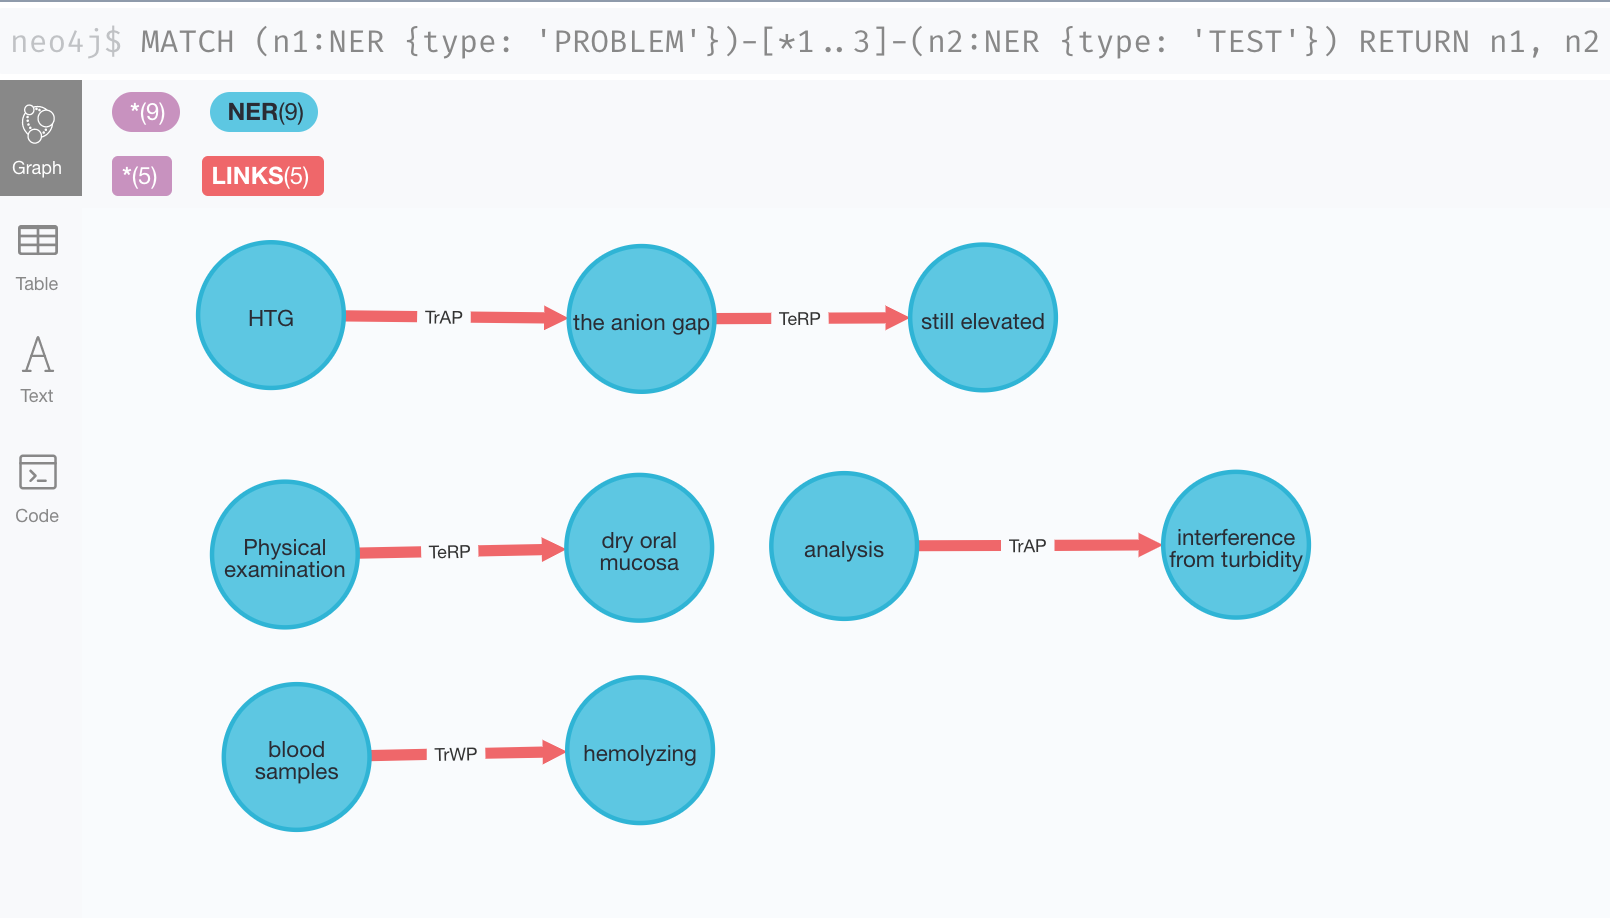

In [ ]:
query_string = '''
MATCH (n1)-[r]-(n2)
WHERE n1.name='HTG'
RETURN n1.name, n1.type, r.relation, n2.name, n2.type
'''
df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
df

,n1.name,n1.type,r.relation,n2.name,n2.type
0,HTG,PROBLEM,TrAP,the anion gap,TEST
1,HTG,PROBLEM,TrAP,a reduction,TREATMENT


In [ ]:
query_string = '''
MATCH (n1)-[r1]-(n2)
WHERE n2.name STARTS WITH 'a'
RETURN n1.name, n1.type, r1.relation, n2.name, n2.type
'''
df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
df

,n1.name,n1.type,r1.relation,n2.name,n2.type
0,interference from turbidity,PROBLEM,TrAP,analysis,TEST
1,T2DM,PROBLEM,TrAP,atorvastatin,TREATMENT
2,HTG,PROBLEM,TrAP,a reduction,TREATMENT


In [ ]:
query = """
    MATCH (n1:NER {type: $prob})-[*1..3]-(n2:NER {type: $treat})
    RETURN n1.name AS problem, n2.name AS treatment
"""

params = {'prob':'PROBLEM', 'treat':'TREATMENT'}

df = pd.DataFrame([dict(_) for _ in conn.query(query, parameters=params)])
df

,problem,treatment
0,HTG,a reduction
1,still elevated,a reduction
2,T2DM,atorvastatin


In [ ]:
conn.close()

# Posology Relation Extraction


## Pipeline

In [ ]:
documenter = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencer = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")

words_embedder = nlp.WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("embeddings")

pos_tagger = nlp.PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("pos_tags")

ner_tagger = medical.NerModel()\
    .pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")

ner_chunker = medical.NerConverterInternal()\
    .setInputCols(["sentences", "tokens", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = nlp.DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentences", "pos_tags", "tokens"])\
    .setOutputCol("dependencies")

reModel = medical.RelationExtractionModel()\
    .pretrained("posology_re")\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)

pipeline = nlp.Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer,
    words_embedder,
    pos_tagger,
    ner_tagger,
    ner_chunker,
    dependency_parser,
    reModel
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
ner_posology download started this may take some time.
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]


In [ ]:
def get_relations_df (results, col='relations'):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.result,
          rel.metadata['entity1'],
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'],
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'],
          rel.metadata['confidence']
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])

  return rel_df

**Create a light pipeline for annotating free text**

In [ ]:
text = """
A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ),
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with acute hepatitis, and obesity with a body mass index ( BMI ) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. Two weeks prior to presentation, she was treated with a five-day course of amoxicillin for a respiratory tract infection. She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for starvation ketosis, as she reported poor oral intake for three days prior to admission. However, serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL, the anion gap was still elevated at 21, serum bicarbonate was 16 mmol/L, triglyceride level peaked at 2050 mg/dL, and lipase was 52 U/L. The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again. The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL, within 24 hours. Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use. The patient was seen by the endocrinology service and she was discharged on 1 unit of Advil for 5 days after meals, 40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg two times a day. It was determined that all SGLT2 inhibitors should be discontinued indefinitely.
She had a close follow-up with endocrinology post-discharge.
"""

lmodel = nlp.LightPipeline(model)

results = lmodel.fullAnnotate(text)

rel_df = get_relations_df (results)

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,DURATION-DRUG,DURATION,484,491,five-day,DRUG,503,513,amoxicillin,1.0
1,DRUG-DURATION,DRUG,671,683,dapagliflozin,DURATION,685,698,for six months,1.0
2,DRUG-ROUTE,DRUG,1915,1921,insulin,ROUTE,1923,1926,drip,1.0
3,DOSAGE-DRUG,DOSAGE,2227,2232,1 unit,DRUG,2237,2241,Advil,1.0
4,DRUG-DURATION,DRUG,2237,2241,Advil,DURATION,2243,2252,for 5 days,1.0
5,DRUG-DOSAGE,DRUG,2237,2241,Advil,DOSAGE,2267,2274,40 units,1.0
6,DRUG-DOSAGE,DRUG,2237,2241,Advil,DOSAGE,2306,2313,12 units,1.0
7,DOSAGE-DRUG,DOSAGE,2267,2274,40 units,DRUG,2279,2294,insulin glargine,1.0
8,DRUG-FREQUENCY,DRUG,2279,2294,insulin glargine,FREQUENCY,2296,2303,at night,1.0
9,DOSAGE-DRUG,DOSAGE,2306,2313,12 units,DRUG,2318,2331,insulin lispro,1.0


## Neo4j Connection

In [ ]:
from neo4j import GraphDatabase
import time
from tqdm import tqdm

### Connection Helper Class & Functions

In [ ]:
class Neo4jConnection:

    def __init__(self, uri, user, pwd):

        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None

        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):

        if self.__driver is not None:
            self.__driver.close()

    def query(self, query, parameters=None, db=None):

        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None

        try:
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

In [ ]:
def update_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.
    # Especially for large datasets.
    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query, parameters={'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total, "batches":batch, "time":time.time()-start}
        print(result)

    return result

In [ ]:
def add_ners_rels(rows, batch_size=10000):
    # Adds NER nodes to the Neo4j graph as a batch job.
    query = '''
    //chunk1 NERs
    UNWIND $rows as row
    MERGE(n1:NER{name:row.chunk1}) ON CREATE SET n1.type=row.entity1

    //chunk2 NERs
    MERGE(n2:NER{name:row.chunk2}) ON CREATE SET n2.type=row.entity2

    //connect NERs
    WITH row, n1, n2
    MERGE (n1)-[:LINKS{relation:row.relation}]->(n2)

    WITH n1
    MATCH (n1)
    RETURN count(*) as total
    '''

    return update_data(query, rows, batch_size)

In [ ]:
uri = 'neo4j+s://5731566c.databases.neo4j.io'
pwd = 'JBJUYsLaCf8jJji7DSh3aSgkgM1c1wHFb38l2XbuDPk'
user= 'neo4j'

conn = Neo4jConnection(uri=uri, user=user , pwd=pwd)

**Important Note :** Before run any Neo4j query, you should delete all nodes and relatioships.

In [ ]:
delete_all_nodes = 'MATCH (n) DETACH DELETE n;'
conn.query(delete_all_nodes)

[]

In [ ]:
const_ners = 'CREATE CONSTRAINT ners IF NOT EXISTS ON (n:NER) ASSERT n.name IS UNIQUE'
conn.query(const_ners)

[]

In [ ]:
add_ners_rels(rel_df)

{'total': 13, 'batches': 1, 'time': 0.33504748344421387}


{'total': 13, 'batches': 1, 'time': 0.33504748344421387}

**Visualization at Neo4j Sandbox**

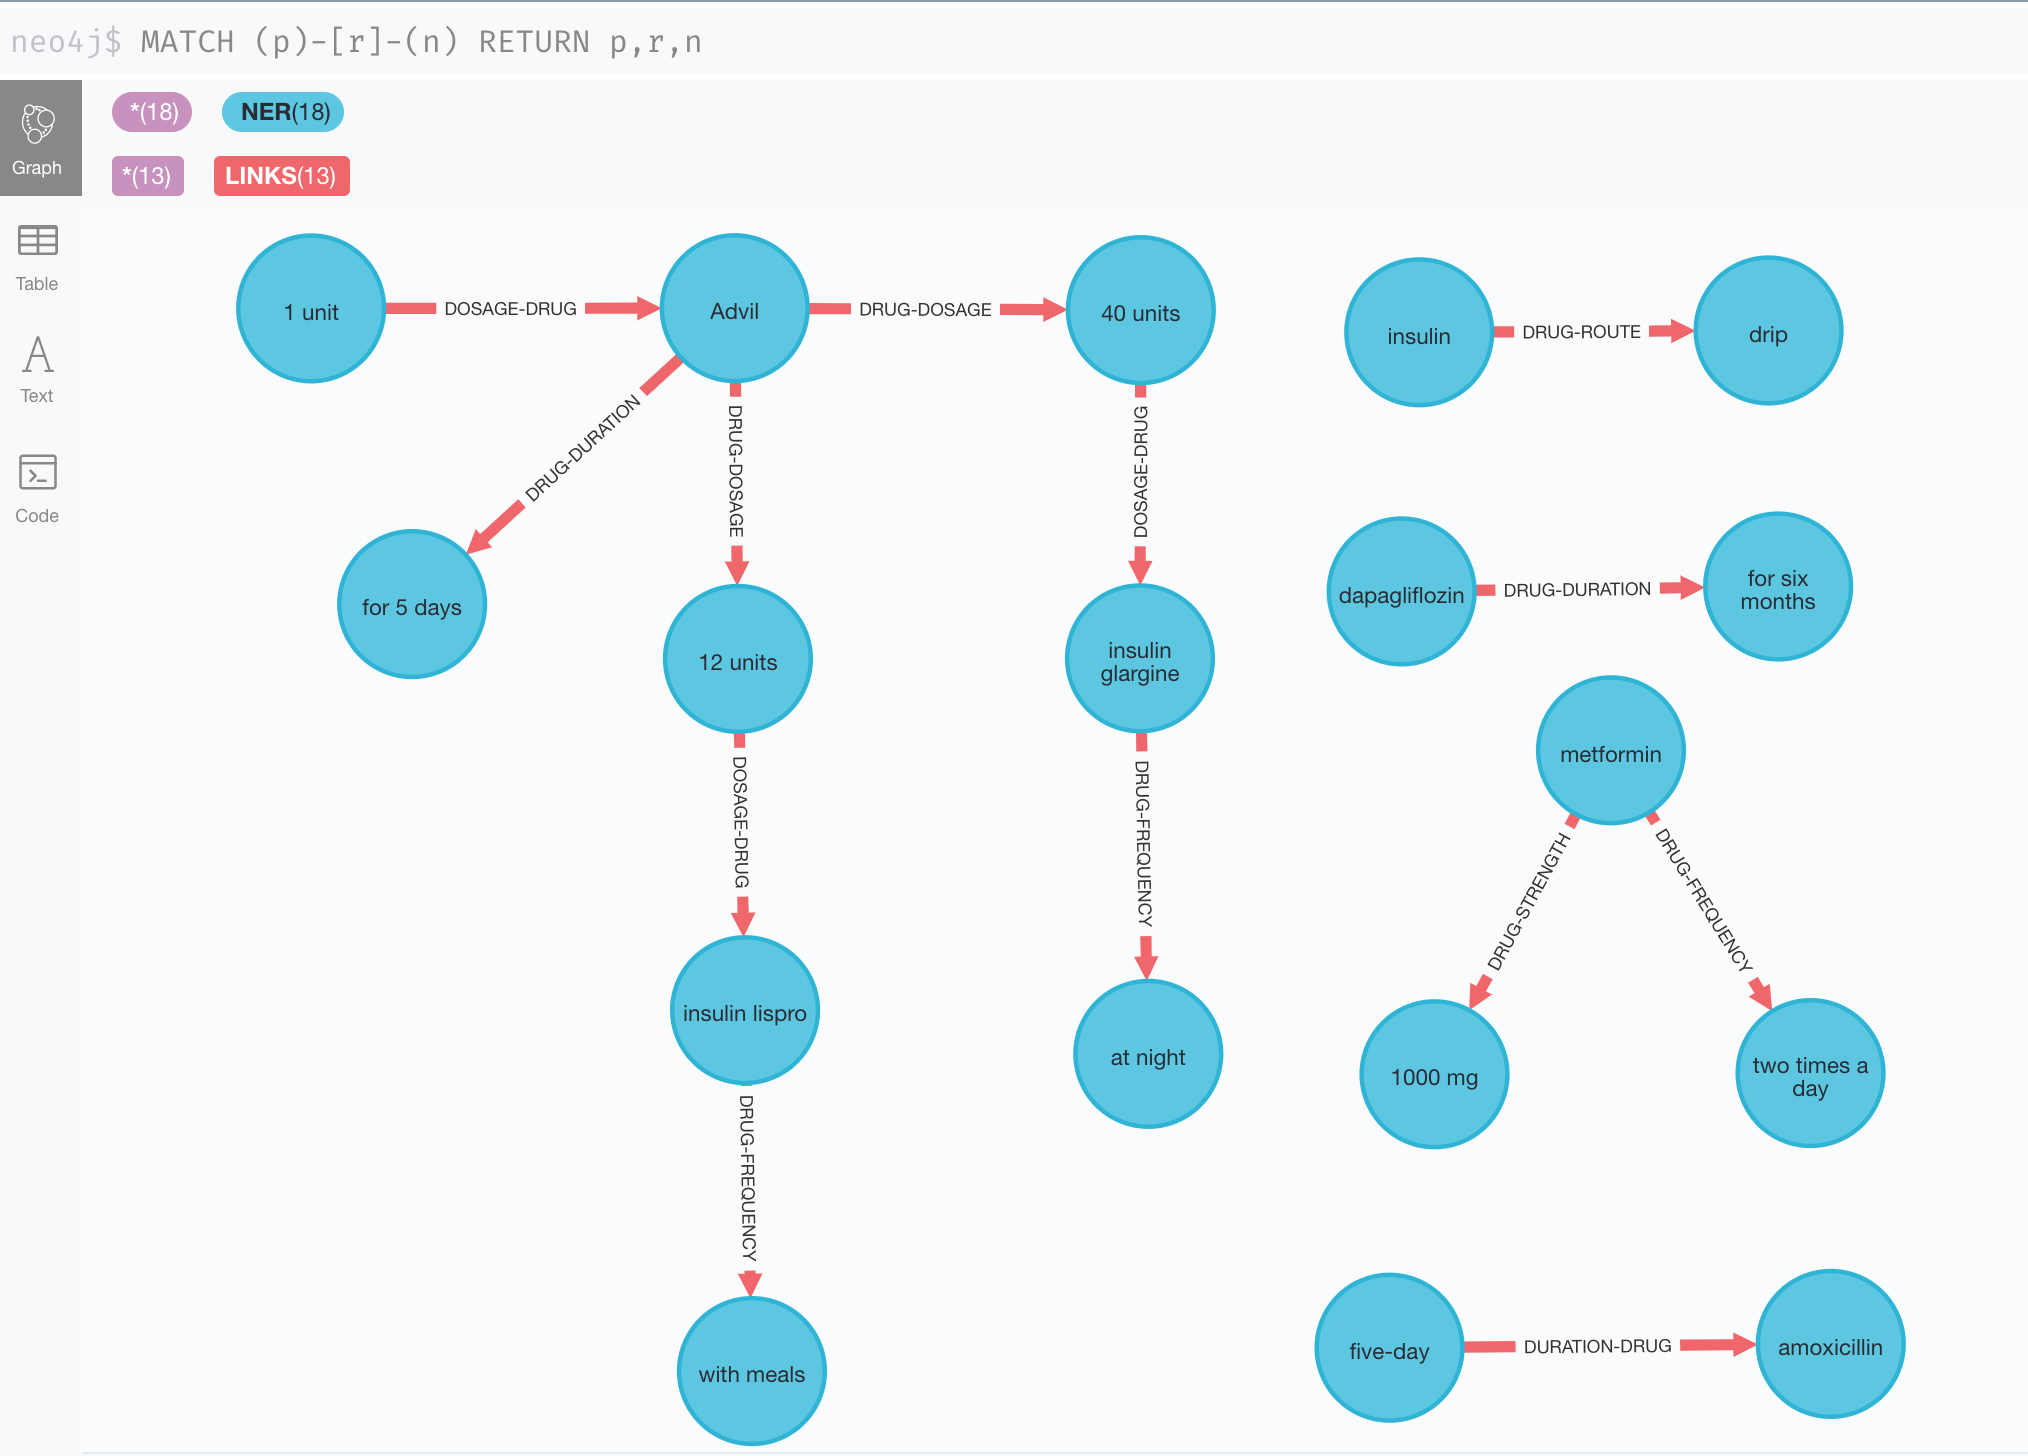

### Quering the Neo4j Database to Get Some Results

In [ ]:
query_string = '''
MATCH (n1)-[r]-(n2)
RETURN n1.name, n1.type, r.relation, n2.name, n2.type
'''
all_nodes_rels = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
all_nodes_rels

,n1.name,n1.type,r.relation,n2.name,n2.type
0,insulin glargine,DRUG,DRUG-FREQUENCY,at night,FREQUENCY
1,insulin glargine,DRUG,DOSAGE-DRUG,40 units,DOSAGE
2,12 units,DOSAGE,DOSAGE-DRUG,insulin lispro,DRUG
3,12 units,DOSAGE,DRUG-DOSAGE,Advil,DRUG
4,insulin lispro,DRUG,DRUG-FREQUENCY,with meals,FREQUENCY
5,insulin lispro,DRUG,DOSAGE-DRUG,12 units,DOSAGE
6,metformin,DRUG,DRUG-FREQUENCY,two times a day,FREQUENCY
7,metformin,DRUG,DRUG-STRENGTH,1000 mg,STRENGTH
8,amoxicillin,DRUG,DURATION-DRUG,five-day,DURATION
9,for six months,DURATION,DRUG-DURATION,dapagliflozin,DRUG


In [ ]:
query_string = '''
MATCH (n1)-[r]-(n2)
WHERE n1.name='Advil'
RETURN n1.name, n1.type, r.relation, n2.name, n2.type
'''
advil_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
advil_df

,n1.name,n1.type,r.relation,n2.name,n2.type
0,Advil,DRUG,DRUG-DURATION,for 5 days,DURATION
1,Advil,DRUG,DOSAGE-DRUG,1 unit,DOSAGE
2,Advil,DRUG,DRUG-DOSAGE,12 units,DOSAGE
3,Advil,DRUG,DRUG-DOSAGE,40 units,DOSAGE


**Visualization at Neo4j Sandbox**

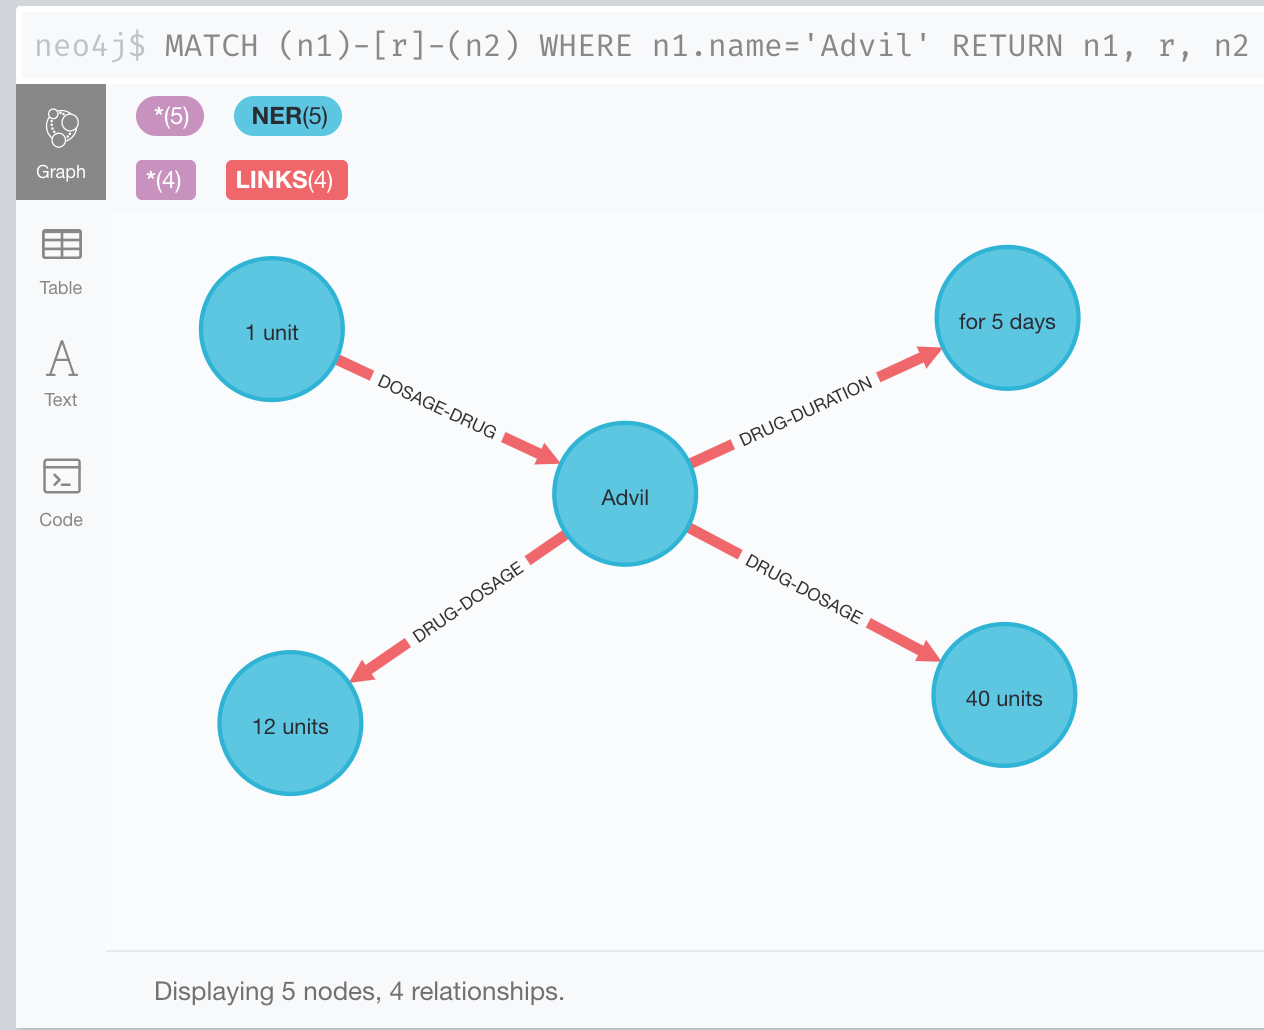

In [ ]:
query_string = '''
MATCH (n1)-[r1]-(n2)
WHERE n2.name STARTS WITH 'insulin'
RETURN n1.name, n1.type, r1.relation, n2.name, n2.type
'''
insulin_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
insulin_df

,n1.name,n1.type,r1.relation,n2.name,n2.type
0,at night,FREQUENCY,DRUG-FREQUENCY,insulin glargine,DRUG
1,40 units,DOSAGE,DOSAGE-DRUG,insulin glargine,DRUG
2,with meals,FREQUENCY,DRUG-FREQUENCY,insulin lispro,DRUG
3,12 units,DOSAGE,DOSAGE-DRUG,insulin lispro,DRUG
4,drip,ROUTE,DRUG-ROUTE,insulin,DRUG


In [ ]:
query_string = '''
MATCH (n1:NER)-[r1:LINKS]-(n2:NER)-[r2:LINKS]-(n3:NER)
WHERE n1.name='Advil' AND n3.name STARTS WITH 'insulin'
RETURN n1.name, n1.type, r1.relation, n2.name, n2.type, r2.relation, n3.name, n3.type
'''
advil_insulin_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
advil_insulin_df

,n1.name,n1.type,r1.relation,n2.name,n2.type,r2.relation,n3.name,n3.type
0,Advil,DRUG,DRUG-DOSAGE,40 units,DOSAGE,DOSAGE-DRUG,insulin glargine,DRUG
1,Advil,DRUG,DRUG-DOSAGE,12 units,DOSAGE,DOSAGE-DRUG,insulin lispro,DRUG


In [ ]:
query_string = '''
MATCH (n1:NER)-[r1:LINKS]-(n2:NER)-[r2:LINKS]-(n3:NER)
WHERE n1.name='Advil'
RETURN n1.name, n1.type, r1.relation, n2.name, n2.type, r2.relation, n3.name, n3.type
'''
advil_rel_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
advil_rel_df

,n1.name,n1.type,r1.relation,n2.name,n2.type,r2.relation,n3.name,n3.type
0,Advil,DRUG,DRUG-DOSAGE,12 units,DOSAGE,DOSAGE-DRUG,insulin lispro,DRUG
1,Advil,DRUG,DRUG-DOSAGE,40 units,DOSAGE,DOSAGE-DRUG,insulin glargine,DRUG


In [ ]:
query = """
    MATCH (n1:NER {type: $drug})-[*1..3]-(n2:NER {type: $dosage})
    RETURN n1.name AS drug, n2.name AS dosage
"""

params = {'drug':'DRUG', 'dosage':'DOSAGE'}

drug_dosage_df = pd.DataFrame([dict(_) for _ in conn.query(query, parameters=params)])
drug_dosage_df

,drug,dosage
0,insulin glargine,40 units
1,insulin glargine,1 unit
2,insulin glargine,12 units
3,insulin lispro,12 units
4,insulin lispro,1 unit
5,insulin lispro,40 units
6,Advil,1 unit
7,Advil,12 units
8,Advil,40 units


In [ ]:
query = """
    MATCH (n1:NER {type: $drug})<-[*1..3]-(n2:NER {type: $dosage})
    RETURN n2.name AS dosage, n1.name AS drug
"""

params = {'drug':'DRUG', 'dosage':'DOSAGE'}

dosage_drug_df = pd.DataFrame([dict(_) for _ in conn.query(query, parameters=params)])
dosage_drug_df

,dosage,drug
0,40 units,insulin glargine
1,1 unit,insulin glargine
2,12 units,insulin lispro
3,1 unit,insulin lispro
4,1 unit,Advil


In [ ]:
conn.close()

# Using Public Spark NLP with Graph Extraction to Create a Knowledge Graph

## Pipeline

In [ ]:
documentAssembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence = nlp.SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

embeddings = nlp.WordEmbeddingsModel.pretrained() \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

ner_tagger = nlp.NerDLModel.pretrained() \
    .setInputCols(["document", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_chunker = medical.NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

posTagger = nlp.PerceptronModel.pretrained() \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("pos")

dependencyParser = nlp.DependencyParserModel.pretrained() \
    .setInputCols(["sentence", "pos", "token"]) \
    .setOutputCol("dependency")

typedDependencyParser = nlp.TypedDependencyParserModel.pretrained() \
    .setInputCols(["dependency", "pos", "token"]) \
    .setOutputCol("dependency_type")

graph_extraction = nlp.GraphExtraction()\
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("graph") \
    .setMergeEntities(True)\
    .setExplodeEntities(True)\
#    .setRelationshipTypes(["prefer-LOC"])

all_pipeline = nlp.Pipeline().setStages([
    documentAssembler,
    sentence,
    tokenizer,
    embeddings,
    ner_tagger,
    ner_chunker,
    posTagger,
    dependencyParser,
    typedDependencyParser,
    graph_extraction
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

all_model = all_pipeline.fit(empty_data)

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
dependency_typed_conllu download started this may take some time.
Approximate size to download 2.4 MB
[OK!]


In [ ]:
def get_graph_result(result):
    result_pd = result.select('id', 'graph').toPandas()
    result_pd = result_pd.explode('graph')

    result_pd.graph = result_pd.graph.apply(lambda x : {"graph" : x[3],
                                                        "entities": x[4]['entities'],
                                                        "right_path" : x[4]['right_path'].split(","),
                                                        "left_path" : x[4]['left_path'].split(",")}
                                                       )

    df_graph = pd.DataFrame()
    df_graph['graph'] = result_pd['graph'].apply(lambda x:x['graph'])
    df_graph['relation'] = result_pd['graph'].apply(lambda x:x['entities'])
    df_graph['entity1'] = result_pd['graph'].apply(lambda x:x['entities'].split(",")[0])
    df_graph['chunk1'] = result_pd['graph'].apply(lambda x:x['left_path'][-1])
    df_graph['chunk2'] = result_pd['graph'].apply(lambda x:x['right_path'][-1])
    df_graph['entity2'] = result_pd['graph'].apply(lambda x:x['entities'].split(",")[-1])
    df_graph['right_path'] = result_pd['graph'].apply(lambda x:x['right_path'])
    df_graph['left_path'] = result_pd['graph'].apply(lambda x:x['left_path'])
    df_graph['length_left_path'] = result_pd['graph'].apply(lambda x:len(x['left_path']))


    return df_graph.reset_index()

In [ ]:
text = ["John Snow was born in England. John Snow lives in New York.",
        "Peter lives in New York. Peter works at Microsoft",
        "Mary was born in Paris. Mary works in Google",
        "Google is based on US",
        "Mike works in Washington.",
        "Washington is the capital of US",
        "England is located in Europe",
        "Paris is the capital of France",
        "US is located in North America"
       ]

ids =  list(range(1, len(text)+1))

df = spark.createDataFrame(pd.DataFrame({"id": ids, "text" : text }))

In [ ]:
results = all_model.transform(df)

In [ ]:
results_pd = get_graph_result(results)
results_pd

,index,graph,relation,entity1,chunk1,chunk2,entity2,right_path,left_path,length_left_path
0,0,born,"PER,LOC",PER,John Snow,England,LOC,"[born, flat, England]","[born, flat, John Snow]",3
1,0,lives,"PER,LOC",PER,John Snow,New York,LOC,"[lives, flat, New York]","[lives, flat, John Snow]",3
2,1,lives,"PER,LOC",PER,Peter,New York,LOC,"[lives, flat, New York]","[lives, flat, Peter]",3
3,1,works,"PER,ORG",PER,Peter,Microsoft,ORG,"[works, nsubj, Microsoft]","[works, nsubj, Peter]",3
4,2,born,"PER,LOC",PER,Mary,Paris,LOC,"[born, flat, Paris]","[born, flat, Mary]",3
5,2,works,"PER,ORG",PER,Mary,Google,ORG,"[works, nsubj, Google]","[works, nsubj, Mary]",3
6,3,based,"ORG,LOC",ORG,Google,US,LOC,"[based, flat, US]","[based, flat, Google]",3
7,4,works,"PER,LOC",PER,Mike,Washington,LOC,"[works, nsubj, Washington]","[works, nsubj, Mike]",3
8,5,capital,"LOC,LOC",LOC,Washington,US,LOC,"[capital, flat, US]","[capital, flat, Washington]",3
9,6,located,"LOC,LOC",LOC,England,Europe,LOC,"[located, flat, Europe]","[located, flat, England]",3


In [ ]:
def get_triples(x):

    triples = []
    for a in range(0, len(x)-2, 2):
        triples.append((x[a], x[a+1], x[a+2]))

    return triples

In [ ]:
kg_df = pd.DataFrame()
kg_df["n1"] = results_pd.chunk1
kg_df["entity1"] = results_pd.entity1
kg_df["relation"] = results_pd.right_path.apply(get_triples).explode().apply(lambda x : x[0])
kg_df["relation_type"] = results_pd.right_path.apply(get_triples).explode().apply(lambda x : x[1])
kg_df["n2"] = results_pd.right_path.apply(get_triples).explode().apply(lambda x : x[2])
kg_df["entity2"] = results_pd.entity2
kg_df

,n1,entity1,relation,relation_type,n2,entity2
0,John Snow,PER,born,flat,England,LOC
1,John Snow,PER,lives,flat,New York,LOC
2,Peter,PER,lives,flat,New York,LOC
3,Peter,PER,works,nsubj,Microsoft,ORG
4,Mary,PER,born,flat,Paris,LOC
5,Mary,PER,works,nsubj,Google,ORG
6,Google,ORG,based,flat,US,LOC
7,Mike,PER,works,nsubj,Washington,LOC
8,Washington,LOC,capital,flat,US,LOC
9,England,LOC,located,flat,Europe,LOC


## Neo4j Connection

In [ ]:
from neo4j import GraphDatabase
import time
from tqdm import tqdm

### Connection Helper Class & Functions

In [ ]:
class Neo4jConnection:

    def __init__(self, uri, user, pwd):

        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None

        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):

        if self.__driver is not None:
            self.__driver.close()

    def query(self, query, parameters=None, db=None):

        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None

        try:
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

In [ ]:
def update_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.
    # Especially for large datasets.
    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query, parameters={'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total, "batches":batch, "time":time.time()-start}
        print(result)

    return result

In [ ]:
def add_ners_rels(rows, batch_size=10000):
    # Adds NER nodes to the Neo4j graph as a batch job.
    query = '''
    //chunk1 NERs
    UNWIND $rows as row
    MERGE(n1:NER{name:row.n1}) ON CREATE SET n1.type=row.entity1

    //chunk2 NERs
    MERGE(n2:NER{name:row.n2}) ON CREATE SET n2.type=row.entity2

    //connect NERs
    WITH row, n1, n2
    MERGE (n1)-[:LINKS{relation:row.relation, rel_type:row.relation_type}]->(n2)

    WITH n1
    MATCH (n1)
    RETURN count(*) as total
    '''

    return update_data(query, rows, batch_size)

In [ ]:
uri = 'neo4j+s://5731566c.databases.neo4j.io'
pwd = 'JBJUYsLaCf8jJji7DSh3aSgkgM1c1wHFb38l2XbuDPk'
user= 'neo4j'

conn = Neo4jConnection(uri=uri, user=user , pwd=pwd)

**Important Note :** Before run any Neo4j query, you should delete all nodes and relatioships.

In [ ]:
delete_all_nodes = 'MATCH (n) DETACH DELETE n;'
conn.query(delete_all_nodes)

[]

In [ ]:
const_ners = 'CREATE CONSTRAINT ners IF NOT EXISTS ON (n:NER) ASSERT n.name IS UNIQUE'
conn.query(const_ners)

[]

In [ ]:
add_ners_rels(kg_df)

{'total': 12, 'batches': 1, 'time': 0.2200455665588379}


{'total': 12, 'batches': 1, 'time': 0.2200455665588379}

**Visualization at Neo4j Sandbox**

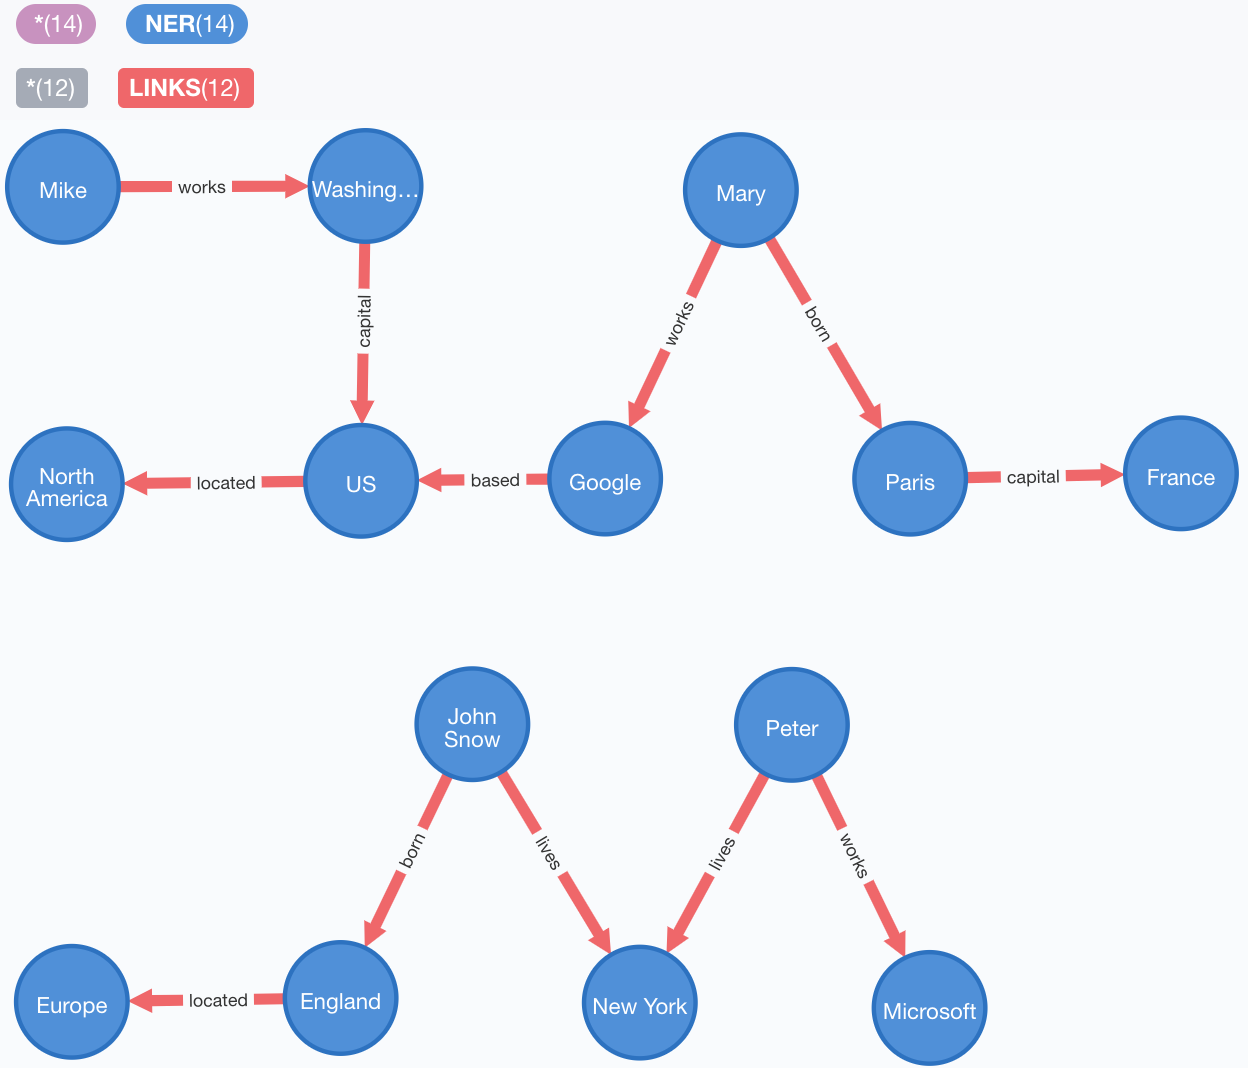

### Quering the Neo4j Database to Get Some Results

In [ ]:
query_string = '''
MATCH (n1)-[r]-(n2)
RETURN n1.name, n1.type, r.relation, n2.name, n2.type
'''
all_nodes_rels = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
all_nodes_rels

,n1.name,n1.type,r.relation,n2.name,n2.type
0,Mary,PER,works,Google,ORG
1,Mary,PER,born,Paris,LOC
2,Google,ORG,works,Mary,PER
3,Google,ORG,based,US,LOC
4,Mike,PER,works,Washington,LOC
5,Washington,LOC,capital,US,LOC
6,Washington,LOC,works,Mike,PER
7,England,LOC,born,John Snow,PER
8,England,LOC,located,Europe,LOC
9,Paris,LOC,born,Mary,PER


In [ ]:
query_string = '''
MATCH (n1)-[r]->(n2)
WHERE r.relation='lives'
RETURN n1.name, n1.type, r.relation, n2.name, n2.type
'''
df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
df

,n1.name,n1.type,r.relation,n2.name,n2.type
0,John Snow,PER,lives,New York,LOC
1,Peter,PER,lives,New York,LOC


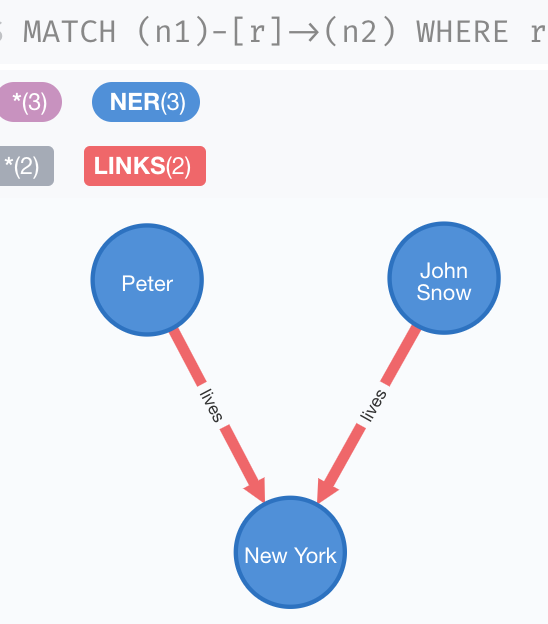

In [ ]:
# The people who live in New York works at which company?
query_string = '''
MATCH (n1)-[r]->(n2)
MATCH (n1)-[r2]->(n3)
WHERE r.relation='lives' AND n2.name='New York' AND r2.relation='works'
RETURN n1.name, n1.type, r.relation, n2.name, n2.type, r2.relation, n3.name, n3.type
'''
df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
df

,n1.name,n1.type,r.relation,n2.name,n2.type,r2.relation,n3.name,n3.type
0,Peter,PER,lives,New York,LOC,works,Microsoft,ORG


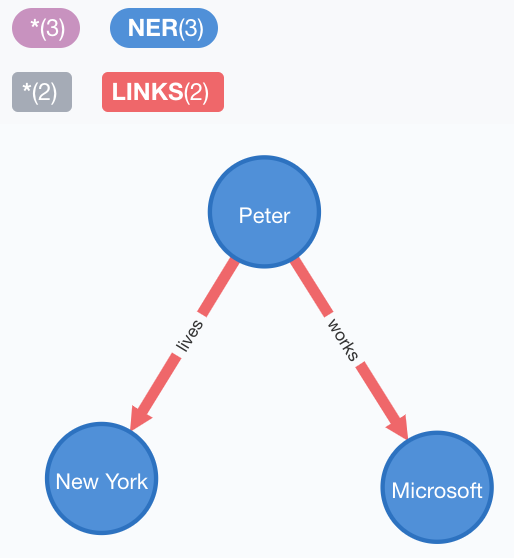

In [ ]:
# The people who work at US born in which city?
query_string = '''
MATCH (n1)-[r1]->(n2)
MATCH (n1)<-[r2]->(n3)-[r3]->(n4)
WHERE r1.relation='based' AND n2.name='US' AND r2.relation='works' AND r3.relation='born'
RETURN n2.name AS country, n1.name AS organization, n3.name AS person, n4.name AS city
'''
df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
df

,country,organization,person,city
0,US,Google,Mary,Paris


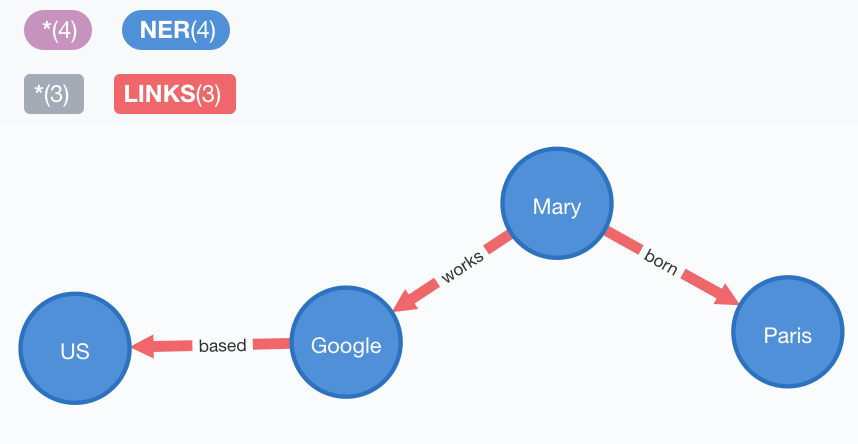